# Upstream regulation network reconstruction

The following code defines the main parameter and data considered as input: 
- SPARQL_ENDPOINT : the main PathwayCommons (PC) SPARQL endpoint 
- CHUNKS_SIZE : the number of genes to be processed within each PC query
- MAX_DEPTH : the maximum depth of exploration, can be null to explore the full regulation graph
- DATA_SOURCES : used to limit the data source to be explored. Must be a list of values from : bind, biogrid, corum, ctd, dip, drugbank, hprd, humancyc, inoh, intact, kegg, mirtarbase, netpath, panther, pid, psp, reactome, reconx, smpdb, wp, intact_complex, msigdb. 

In [26]:
from typing import List, Any

from IPython.display import display, Markdown, Latex
from rdflib import Graph, RDF, RDFS, Namespace
from SPARQLWrapper import SPARQLWrapper, JSON
from string import Template

import networkx as nx
import matplotlib.pyplot as plt
#from nxpd import draw

import requests
import json
import io
import time
import csv

INPUT_GENES = ['JUN/FOS', 'SCN5A']

SPARQL_ENDPOINT = "http://rdf.pathwaycommons.org/sparql"  # type: str
CHUNKS_SIZE = 10  # type: int
MAX_DEPTH = 2 # type: int
SKIP_SMALL_MOLECULES = True # type: Boolean
#DATA_SOURCES = ['pid', 'humancyc', 'panther', 'msigdb']
DATA_SOURCES = []  # type: List[str]

HAS_MAX_DEPTH = False
try:
  MAX_DEPTH
except NameError:
  HAS_MAX_DEPTH = False
else:
  HAS_MAX_DEPTH = True

HAS_DATA_SOURCES = False
try:
  DATA_SOURCES
except NameError:
  HAS_DATA_SOURCES = False
else:
  HAS_DATA_SOURCES = True

# 1. Pathway Commons template SPARQL query
The query will be post-processed to integrate filters on gene names `$filter_Chunks`, for skipping small molecules `$filter_SkipSmallMollecules`, and considering only a subset of data sources `$filter_DataSources`. 

In [13]:
tpl_select_reg_query = """
PREFIX bp: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?controllerName ?controlType ?controlledName ?ds WHERE {
    $filter_Chunks
    $filter_SkipSmallMollecules
    $filter_DataSources
    
    ?participant bp:displayName ?controlledName ;
        rdf:type ?controlledType .
    ?controller bp:displayName ?controllerName ;
        rdf:type ?controllerType . 
    
    ?controlled bp:participant ?participant .

    ?tempReac a bp:TemplateReactionRegulation ; 
        bp:controlled ?controlled ; 
        bp:controller ?controller ; 
        bp:controlType ?controlType ; 
        bp:dataSource ?source . 
} 
"""

The query is based on the BioPax ontology. It aims at matching a graph pattern on the full Pathway Commons knowledge base. The following diagram shows variable graph nodes (dashed circles), fixed nodes (rectangle), and what we search for in red. 

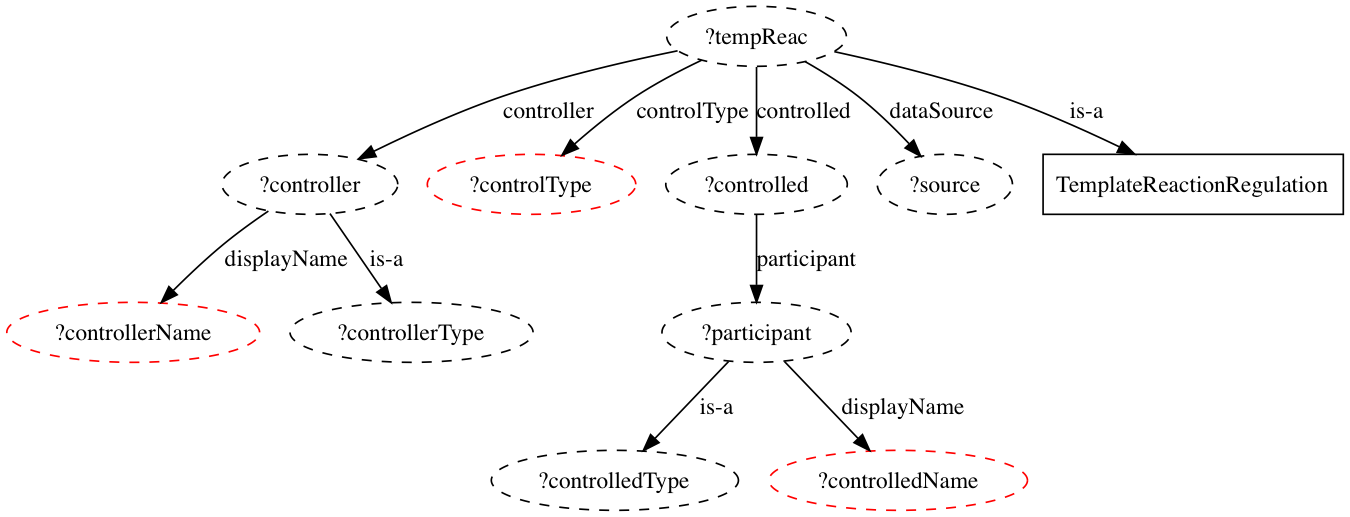

In [14]:
from nxpd import draw
bgp = nx.DiGraph()
bgp.graph['dpi'] = 120

bgp.add_node("?controllerName", color="red")
bgp.add_node("?controlType", color="red")
bgp.add_node("?controlledName", color="red")

bgp.add_edge("?participant", "?controlledName", label="displayName")
bgp.add_edge("?participant", "?controlledType", label="is-a")
bgp.add_edge("?controller", "?controllerName", label="displayName")
bgp.add_edge("?controller", "?controllerType", label="is-a")
bgp.add_edge("?controlled", "?participant", label="participant")
bgp.add_edge("?tempReac", "TemplateReactionRegulation", label="is-a")
bgp.add_edge("?tempReac", "?controlled", label="controlled")
bgp.add_edge("?tempReac", "?controller", label="controller")
bgp.add_edge("?tempReac", "?controlType", label="controlType")
bgp.add_edge("?tempReac", "?source", label="dataSource")
for e in bgp.edges():
    for i in range(0,2):
        if "?" in e[i]:
            bgp.add_node(e[i], style='dashed')
        else: 
            bgp.add_node(e[i], shape='rectangle')
    
draw(bgp, show='ipynb')

### Splitting a list of genes based on `CHUNKS_SIZE`

In [15]:
def gen_chunks(list_of_genes):
    """
    """
    chunks_list = []
    chunk = []
    cpt = 0
    for gene in list_of_genes:
        chunk.append(gene)
        cpt += 1
        if ((cpt % CHUNKS_SIZE) == 0):
            chunks_list.append(chunk)
            chunk = []
    if (len(chunk) > 0):
        chunks_list.append(chunk)
    return chunks_list

### Generation of a SPARQL Filter clause to restrict data sources
Produces something like
```
FILTER (?source IN (<http://pathwaycommons.org/pc2/pid>, <http://pathwaycommons.org/pc2/humancyc>))
```

In [16]:
def gen_data_source_filter(data_sources):
    """
    generates a SPARQL Filter clause aimed at 
    limiting the possible values of a ?source vairable
    """
    filter_clause = ''
    if len(data_sources) > 0 : 
        filter_clause = 'FILTER (?source IN ('
        for ds in data_sources :
            dsUri = '<http://pathwaycommons.org/pc2/' + ds.lower() + '>'
            filter_clause = filter_clause + dsUri + ', '
        k = filter_clause.rfind(", ")
        filter_clause = filter_clause[:k]
        filter_clause = filter_clause + ')) .'
    return filter_clause

### Generation of a SPARQL Filter clause to restrict gene/protein/etc. names
Produces something like
```
FILTER (
    ((?controlledName = "JUN"^^xsd:string) && (?controllerName != "JUN"^^xsd:string))
    || ((?controlledName = "FOS"^^xsd:string) && (?controllerName != "FOS"^^xsd:string))
```

In [17]:
def gen_chunks_filter(chunks):
    """
    """
    filter_clause = ''
    if len(chunks) > 0 : 
        filter_clause = 'FILTER ( \n'
        for g in chunks :
            filter_clause += '((?controlledName = "' + g + '"^^xsd:string) && (?controllerName != "' + g + '"^^xsd:string)) \n'
            filter_clause +=' || '
        k = filter_clause.rfind(" || ")
        filter_clause = filter_clause[:k]
        filter_clause += ' ) .'
    return filter_clause

### Generation of a SPARQL Filter clause to exclude small molecules
Produces something like
```
FILTER( str(?controllerType) != "http://www.biopax.org/release/biopax-level3.owl#SmallMolecule")
```

In [18]:
def gen_small_mol_filter(skip_small_molecules = True):
    if skip_small_molecules:
        return 'FILTER( str(?controllerType) != "http://www.biopax.org/release/biopax-level3.owl#SmallMolecule")  .'
    else:
        return ''

# 2. Upstream regulation algorithm
Recursive exploration with two stopping criteria: 
- nothing new to explore
- the maximum exploration depth is reached

In [19]:
def upstream_regulation(to_be_explored, already_explored, sif_network, depth, explored_reg):
    """
    """
    
    """ 1st stopping criteria """
    if len(to_be_explored) == 0:
        print("Exploring done")
        return sif_network
    
    """ 2nd stopping criteria """
    if (HAS_MAX_DEPTH and (depth >= MAX_DEPTH)):
        print("Exploring alted due to maximum depth")
        return sif_network
    
    print()
    print('exploration depth ' + str(depth))
    print('to be explored ' + str(to_be_explored))
    
    """ Decomposing protein complexes """
    new_to_be_explored = []
    for name in to_be_explored:
        splits = name.split('/')
        if len(splits) > 1 : 
            print(name + ' decomposed into ' + str(splits))
            new_to_be_explored.extend(splits)
            for s in splits:
                sif_network.append({"source":s, "relation":"PART_OF", "target":name})
    
    for new in new_to_be_explored:
        if new not in to_be_explored:
                to_be_explored.append(new)
    print('to be explored after complex decomposition ' + str(to_be_explored))
    
    """  """
    chunks = gen_chunks(to_be_explored)
    to_be_explored = []
    
    for regulators in chunks :
        print('exploring ' + str(regulators))
        query = Template(tpl_select_reg_query)
        
        fds = gen_data_source_filter(DATA_SOURCES)
        fchunks = gen_chunks_filter(regulators)
        ssm = gen_small_mol_filter(SKIP_SMALL_MOLECULES)
        
        q = query.substitute(filter_DataSources = fds,
                    filter_SkipSmallMollecules = ssm, 
                    filter_Chunks = fchunks)
        
        sparql = SPARQLWrapper(SPARQL_ENDPOINT)
        sparql.setQuery(q)
        sparql.setReturnFormat(JSON)
        results = sparql.query().convert()
        
        already_explored.extend(regulators)
        #print('already explored ' + str(already_explored))
        
        for result in results["results"]["bindings"]:
            source, reg_type, target = result["controllerName"]["value"], result["controlType"]["value"], result["controlledName"]["value"]
            sif_network.append({"source":source, "relation":reg_type, "target":target})
            #print(source + ' --- ' + reg_type + ' --> ' + target)
            
            if source not in already_explored:
                if source not in to_be_explored:
                    to_be_explored.append(source)
                    explored_reg += 1
                    #print('Adding ' + source + ', in to_be_explored')
            #else:
                #print('skipping ' + source + ', already_explored')
        
        print()
        print('Explored ' + str(explored_reg)+ ' regulators')
        
    depth += 1
    upstream_regulation(to_be_explored, already_explored, sif_network, depth, explored_reg)
    
    return sif_network

# 3. RUNNING the algorithm
based on the `INPUT_GENES` list. 

In [20]:
def read_input_genes(filename):
    res = []
    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for row in reader:
            res.append(''.join(row))
    return res

input_genes = read_input_genes('/Users/gaignard-a/Documents/Dev/BRAvo/nathalie-TF.csv')

In [21]:
def get_gene_alias(gene_name):
    res = []
    with open('Homo_sapiens.gene_info', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
        for row in reader:
            synonyms = []
            synonyms.append(row[2])
            synonyms.extend(row[4].split('|'))
            #print(row[2]+ " == " + str(row[4].split('|')))
            #print(synonyms)
            if gene_name in synonyms : 
                res.extend(synonyms)
    res.remove(gene_name)
    return res

alias_jun = get_gene_alias('JUN')
print("%s has for a alias : %s" % ("JUN", alias_jun))
alias_cjun = get_gene_alias('c-Jun')
print("%s has for a alias : %s" % ("c-Jun", alias_cjun))

JUN has for a alias : ['AP-1', 'AP1', 'c-Jun', 'p39']
c-Jun has for a alias : ['JUN', 'AP-1', 'AP1', 'p39']


In [28]:
start_time = time.time()

reconstructed_network = upstream_regulation(["JUN/FOS", "SCN5A"], [], [], depth=0, explored_reg=0)

elapsed_time = round((time.time() - start_time), 2)
print("--- Upstream regulation network in %s seconds ---" % elapsed_time)

G = nx.DiGraph()
for e in reconstructed_network:
#    print(e['source'] + ' --- ' + e['regulation'] + ' --> ' + e['target'])
    G.add_edge(e['source'], e['target'], 
               color = 'g' if (e['relation'] in 'ACTIVATION') else 'r',
               label=e['relation'])

print('Number of nodes = ' + str(len(G.nodes())))
print('Number of edges = ' + str(len(G.edges())))


exploration depth 0
to be explored ['JUN/FOS', 'SCN5A']
JUN/FOS decomposed into ['JUN', 'FOS']
to be explored after complex decomposition ['JUN/FOS', 'SCN5A', 'JUN', 'FOS']
exploring ['JUN/FOS', 'SCN5A', 'JUN', 'FOS']

Explored 147 regulators

exploration depth 1
to be explored ['MAZ', 'POU3F2', 'hsa-miR-6785-5p', 'CREB1', 'CEBPA', 'SPZ1', 'hsa-miR-1321', 'hsa-miR-4739', 'ICER', 'hsa-miR-937-5p', 'hsa-miR-4733-3p', 'hsa-miR-8081', 'TCF3', 'ATF3', 'hsa-miR-149-5p', 'ERK1-2/ELK1', 'FOXM1C', 'ESRRA', 'SRF', 'MYOD1', 'hsa-miR-633', 'hsa-miR-2681-5p', 'hsa-miR-4328', 'hsa-miR-6885-3p', 'hsa-miR-627-5p', 'hsa-miR-187-5p', 'hsa-miR-6816-3p', 'hsa-miR-29c-3p', 'hsa-miR-5089-3p', 'hsa-miR-8080', 'hsa-miR-338-3p', 'hsa-miR-5581-3p', 'hsa-miR-19b-2-5p', 'hsa-miR-5586-5p', 'hsa-miR-3065-3p', 'hsa-miR-323b-3p', 'hsa-miR-548v', 'hsa-miR-29a-3p', 'hsa-miR-19b-1-5p', 'hsa-miR-6854-3p', 'hsa-miR-4530', 'hsa-miR-8083', 'hsa-miR-6872-3p', 'hsa-miR-6077', 'hsa-miR-770-5p', 'hsa-miR-335-5p', 'hsa-miR-222-


Explored 1266 regulators
Exploring alted due to maximum depth
--- Upstream regulation network in 51.5 seconds ---
Number of nodes = 1216
Number of edges = 2336


In [21]:
def write_to_SIF(graph, filename):
    with open(filename, 'w', newline='') as csvfile:
        sif_writer = csv.writer(csvfile, delimiter='\t')
        for e in G.edges(data='label'):
            sif_writer.writerow([e[0], e[2], e[1]])
    print('SIF network written to ' + filename)

write_to_SIF(G, 'out.sif')


SIF network written to out.sif


In [22]:
import operator
centrality = nx.degree_centrality(G)
#centrality = nx.closeness_centrality(G)
#centrality = nx.betweenness_centrality(G)
sorted_centrality = reversed(sorted(centrality.items(), key=operator.itemgetter(1)))
sorted_centrality = list(sorted_centrality)
cpt = 0
md = """
| Gene | Degree Centrality |
|------|------|
"""
for g in sorted_centrality:
    md += "| " + g[0] + " | " + str(g[1]) + " | \n"
    cpt += 1
    if cpt > 9:
        break
#print(md)
display(Markdown(md))


| Gene | Degree Centrality |
|------|------|
| FOS | 0.6423841059602649 | 
| JUN | 0.41721854304635764 | 
| SCN5A | 0.09271523178807947 | 
| MAZ | 0.019867549668874173 | 
| JUN/FOS | 0.019867549668874173 | 
| MYOD1 | 0.013245033112582781 | 
| SP1 | 0.013245033112582781 | 
| CEBPD | 0.013245033112582781 | 
| HSF2 | 0.013245033112582781 | 
| hsa-miR-139-5p | 0.013245033112582781 | 


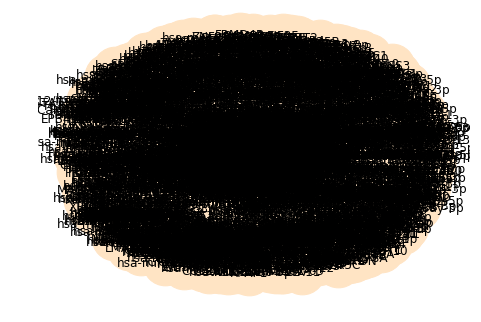

In [15]:
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]

nx.draw_spring(G, 
               with_labels=True, 
               edge_color = colors,
               node_color = 'bisque',
               font_weight='light', 
               node_size = 2000, 
               width = 2)
plt.show()